In [3]:
#__autho__:CH
#__date__:Apr25
# this notebook handles reduced result on [year, month, day, hour] level
# please refer corresponding cells and copy paste to the head of your notebook to avoid redundant data cleaning!
import pandas as pd
import numpy as np
import os
import seaborn
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely
import geojson
import fiona
%pylab inline
cwd = os.getcwd()

output_path = os.path.join(os.path.dirname(cwd), 'output')
data_path = os.path.join(os.path.dirname(cwd), 'data')

Populating the interactive namespace from numpy and matplotlib


In [73]:
file_name = ['reduce_year_ct.txt', 'reduce_month_ct.txt', 'reduce_day_ct.txt', 'reduce_hour_ct.txt', 'reduce_ct.txt']

In [119]:
data = {}
level = ['year', 'month', 'day', 'hour', 'all']
for i in [0,3]:
    dt = np.loadtxt(os.path.join(output_path,file_name[i]), str)
    dt = dt[dt != '''(NR10)"'),''']
    data1 = pd.DataFrame(dt.reshape((dt.shape[0]/3 ,3)), columns=[level[i], 'ct', 'count'])
    print data1.head()
    
    data1.iloc[0,0] = data1.iloc[0,0][1:]
    data1.iloc[-1,-1] = data1.iloc[-1,-1][:-1]

    year_list = data1.apply(lambda x: int(x[0][2:-1].replace('(','')), axis = 1)
    zipcode_list = data1.apply(lambda x: x[1][2:-3], axis = 1)
    counts_list = data1.apply(lambda x: int(x[2][:-2].replace(')','')), axis = 1)
    
    data_ = pd.DataFrame({level[i]: year_list, 'ct':zipcode_list, 'counts': counts_list})
    data[level[i]] = data_
    

       year            ct  count
0  [((2017,  u'5000700'),   82),
1   ((2016,  u'1016500'),  175),
2   ((2015,  u'3032300'),  282),
3   ((2014,  u'4012400'),   73),
4   ((2014,  u'1002000'),  156),
    hour            ct count
0  [((6,  u'4122300'),   3),
1   ((6,  u'1002202'),  22),
2  ((20,  u'3048800'),  19),
3   ((1,  u'3002000'),  28),
4  ((20,  u'3042400'),  10),


for i in [4]:
    dt = np.loadtxt(os.path.join(output_path,file_name[i]), str)
    dt = dt[dt != '''(NR10)"'),''']
    data1 = pd.DataFrame(dt.reshape((dt.shape[0]/6 ,6)), columns=['year','month','day','hour', 'ct', 'count'])
    data1.iloc[0,0] = data1.iloc[0,0][1:]
    data1.iloc[-1,-1] = data1.iloc[-1,-1][:-1]
    
    year_list = data1.apply(lambda x: int(x[0][2:-1].replace('(','')), axis = 1)
    month_list = data1.apply(lambda x: int(x[1][:-1]), axis = 1)
    day_list = data1.apply(lambda x: int(x[2][:-1].replace(')','')), axis = 1)
    hour_list = data1.apply(lambda x: int(x[3][:-1].replace(')','')), axis = 1)
    ct_list = data1.apply(lambda x: int(x[4][:-2].replace(')','')), axis = 1)
    counts_list = data1.apply(lambda x: int(x[5][:-2].replace(')','')), axis = 1)
    
    data_ = pd.DataFrame({'year': year_list, 'month': month_list, 'day': day_list,
                          'hour': hour_list, 'ct':ct_list, 'counts': counts_list})
    data[level[i]] = data_
    

In [91]:
data['year'].head()

,counts,year,zipcode
0,82,2017,5000700
1,175,2016,1016500
2,282,2015,3032300
3,73,2014,4012400
4,156,2014,1002000


In [96]:
data['hour'].head()

,counts,hour,zipcode
0,3,6,4122300
1,22,6,1002202
2,19,20,3048800
3,28,1,3002000
4,10,20,3042400


In [98]:
by_ct = data['year'].groupby('ct', group_keys = False, as_index = False).sum()

In [100]:
# load in zipcode boundaries shapefile
ct_bdr = gpd.read_file(data_path+'/nyct2010_16d/nyct2010.shp')

In [101]:
ct_bdr.head()

,BoroCT2010,BoroCode,BoroName,CDEligibil,CT2010,CTLabel,NTACode,NTAName,PUMA,Shape_Area,Shape_Leng,geometry
0,5000900,5,Staten Island,I,000900,9,SI22,West New Brighton-New Brighton-St. George,3903,2.497010e+06,7729.016794,"POLYGON ((962269.1260375977 173705.5001831055,..."
1,5007400,5,Staten Island,I,007400,74,SI14,Grasmere-Arrochar-Ft. Wadsworth,3902,5.788238e+06,9902.948473,"POLYGON ((967656.8290405273 155637.1314086914,..."
2,1009800,1,Manhattan,I,009800,98,MN19,Turtle Bay-East Midtown,3808,1.906016e+06,5534.199811,"POLYGON ((994133.507019043 214848.8975830078, ..."
3,1010000,1,Manhattan,I,010000,100,MN19,Turtle Bay-East Midtown,3808,1.860938e+06,5692.168737,"POLYGON ((993108.3057861328 216013.1307983398,..."
4,1010200,1,Manhattan,I,010200,102,MN17,Midtown-Midtown South,3807,1.860993e+06,5687.802439,"POLYGON ((992216.5391845703 216507.6870117188,..."


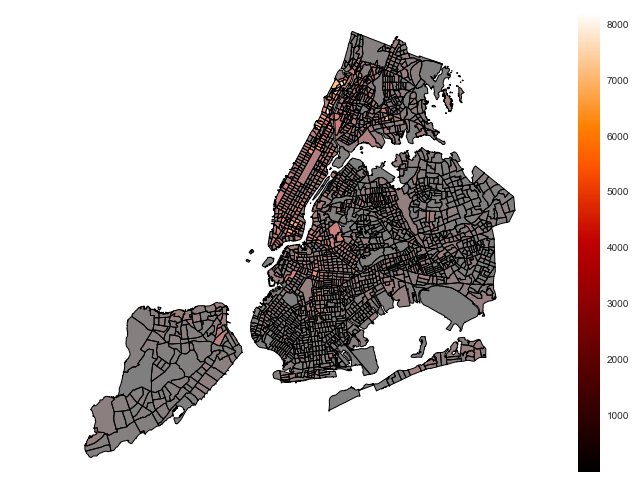

In [102]:
# merge counts by zipcode and shapefile
ct_counts = pd.merge(ct_bdr[['BoroCT2010', 'geometry']], by_ct, left_on='BoroCT2010', right_on='ct')
# mapping
vmin = ct_counts.counts.min()
vmax = ct_counts.counts.max()

ax = ct_counts.plot(column = 'counts', cmap = 'gist_heat');
ax.axis('off')
# plot colorbar
fig2 = ax.get_figure()
fig2.set_size_inches(10, 8)
cax = fig2.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='gist_heat', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# fake up the array of the scalar mappable. Urgh...
sm._A = []
fig2.colorbar(sm, cax=cax)


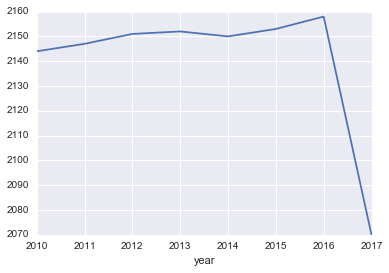

In [103]:
# by year:
by_year = data['year'].groupby('year', group_keys = False).size()
by_year.plot()

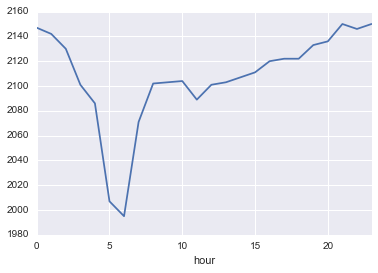

In [122]:
# by hour:
by_hour = data['hour'].groupby('hour', group_keys = False).size()
by_hour.plot()